# Inverted Pendulum DDQN - Grid Search

This script is an extension to the inverted pendulum DQN algorithm in inv_pend.ipynb. This scripts automates the grid search in a hyperparameter space to explore the best performance of DQN.





In [2]:
import random                       # To draw a random batch of samples form the replay buffer
import gymnasium as gym             # To create the inverted pendulum environment
import torch                        
from torch import nn
import torch.optim as optim
import numpy as np
import re
import os
import json
import time
import matplotlib.pyplot as plt

from datetime import datetime

from collections import deque       # replay buffer is a double ended queue that allows elements to be added either to the end or the start

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Setup

In [4]:
class QNet_MLP(nn.Module):
    ''' A QNetwork class that dynamically initialize an MLP Q Net'''
    def __init__(self,input_dim,output_dim,hidden_layer = [64,32]):
        super().__init__()

        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        self.output_dim = output_dim

        for size in hidden_layer:
            self.layers.append(nn.Linear(self.input_dim, size))
            self.input_dim = size
        
        self.layers.append(nn.Linear(self.input_dim,self.output_dim))

        self.to(device)
    
    def forward(self, input_data):
        for layer in self.layers[:-1]:
            input_data = torch.relu(layer(input_data))
        return self.layers[-1](input_data)

In [ ]:
class DDQN_experiment():
    def __init__(self, model_name: str,      # "DQN_MLP_v0" or "DQN_MLP_v1"
                 model_registry, 
                 lr: float, 
                 buffer_size: int, 
                 target_update_freq: int, 
                 gamma: float, 
                 eps_start: float, 
                 eps_decay: int,
                 eps_end: float, 
                 batch_size: int,
                 seed = 42):
        
        self.seed = seed
        
        ''' Defining hyperparameters in the experiment '''
        self.model_name = model_name                                        # Full name of the model
        self.model_class = model_registry[self.model_name]['class']             # The model class "QNet_MLP" or "QNet_test"
        self.model_config = model_registry[self.model_name]['config']       # List of nodes in each hidden layer
        match = re.search(r'v\d+',self.model_name)
        self.model_id = match.group(0) if match else 404                    # Extract the "v0" or "v1" out of model name for abbreviation

        # Hyperparameters of the experiment
        self.lr = lr
        self.buffer_size = buffer_size
        self.target_update_freq = target_update_freq
        self.gamma = gamma
        self.eps_start, self.eps, self.eps_decay, self.eps_end = eps_start, eps_start, eps_decay, eps_end
        self.batch_size = batch_size
        self.episode_train = 5000
        self.min_replay_size = 1000

        # Initialize the train and validation environments
        self.env = gym.make("CartPole-v1")
        self.env_val = gym.make("CartPole-v1")
        self.obs_space = self.env.observation_space.shape[0]
        self.act_space = self.env.action_space.n

        # Initialize the 2 Q networks and the optimizer for the behavior Q_net
        self.Q_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.target_net = self.model_class(self.obs_space, self.act_space, self.model_config)
        self.target_net.load_state_dict(self.Q_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.SGD(self.Q_net.parameters(), lr = self.lr)

        self.save_path = ""                                             # Directory of the current run
        self.model_path = ""                                            # Path to a model 
        self.hyperparam_config = ""                                     # Shortened list of importatnt hyperparameters
        self.reward_history = np.zeros(self.episode_train)
        self.val_history = {}                                           # Monitor which episode had a validation run, the train reward, and the validation (test) reward 

    def create_directory(self):
        ''' Function that creates directory to save model state_dict, architecture, training configuration, and history

        Parameters: 
        ------------
        (hyperparameters for differentiating between different directory)
        
        lr : float
            the learning rate to optimize the Q network
        gamma : float 
            the discount rate in Q learning
        epsilon_decay : integer
            the amount of episode over which the exploratory rate (epsilon) decays
        batch_size : integer
            number of experience drawn from replay buffer to train the behaviour network
        buffer_size : integer
            the number of samples in the replay buffer at a time
        target_udpate_freq : integer
            the amount of step count during the training process before updating the target Q net (loading the parameters of the behaviour net onto the target Q Net)
        

        Returns
        ------------
        name_codified : str
            the shortened name for the current experiment 
        hyperparameters_codified : str
            the shortened string of hyperparameter configuration
        OUTPUT_DIR : path
            the directory to which the training results and model (state_dict and architecture) will be saved
        '''
        timestamp = datetime.now().strftime("%y%m%d_%H%M")

        RESULT_FOLDER = "inv_pend_DDQN_results"
        BASE_DIR = os.getcwd()
        RESULT_DIR = os.path.join(BASE_DIR, RESULT_FOLDER)
        os.makedirs(RESULT_DIR, exist_ok=True)      # Create the directory if one does not already exist

        # Find the trial # of the latest run
        existing_runs = [d for d in os.listdir(RESULT_DIR) if os.path.isdir(os.path.join(RESULT_DIR,d))]
        run_numbers = [int(re.search(r'run_(\d{5})',d).group(1)) for d in existing_runs if re.match(r'run_\d{5}',d)]
        trial_number = max(run_numbers,default=-1)+1

        # Create a folder for the run
        name_codified = f"run_{trial_number:05d}"
        OUTPUT_DIR = os.path.join(RESULT_DIR,name_codified)
        os.makedirs(OUTPUT_DIR, exist_ok=True)      # Create the directory

        # Append the mapping from run # to hyperparameter configuration in a JSON file inside RESULT_DIR
        trial_to_param_path = os.path.join(RESULT_DIR,'trial_to_param.json')
        if os.path.exists(trial_to_param_path):
            with open(trial_to_param_path, "r") as f:
                data = json.load(f)
        else:
            data = {name_codified: []}

        hyperparam_codified = f"{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
        hyperparam_codified_time = f"{timestamp}_{self.model_id}_{self.lr}_{self.buffer_size}_{self.target_update_freq}_{self.gamma}_{self.eps_decay}_{self.batch_size}"
        data[name_codified] = hyperparam_codified_time

        with open(trial_to_param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Store the training configs in JSON file
        training_params = {
            'model_id':             self.model_id,
            'lr':                   self.lr,
            'gamma':                self.gamma,
            'epsilon_decay':        self.eps_decay,
            'batch_size':           self.batch_size,
            'buffer_size':          self.buffer_size,
            'target_update_freq':   self.target_update_freq
        }

        # Store training parameters in each run 
        param_path = os.path.join(OUTPUT_DIR, "param_config.json")
        with open(param_path, "w") as f:
            json.dump({"parameters": training_params}, f, indent=2)

        return name_codified, hyperparam_codified, OUTPUT_DIR
    
    def eps_greedy_policy(self, env, obs, epsilon):      
        ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(obs).unsqueeze(0)
                q_values = self.Q_net(state_tensor)
                action = q_values.argmax().item()

        return action
    
    def prefill_replay(self):
        obs,_ = self.env.reset()
        for _ in range(self.min_replay_size):
            action = self.env.action_space.sample()
            next_obs, reward, term, trunc, _ = self.env.step(action)
            done = term or trunc

            self.replay_buffer.append((obs, action, reward, next_obs, done))
            obs = next_obs if not done else self.env.reset()[0]

    def policy_eval(self, env: gym.Env, n_episode_test = 500, verbose = 0):
        ''' Assess the average reward when following a q_network in a test environment with random state initialization
        
        Parameters:
        env : gymnasium environment
            - Can be either the self.env_test or self.env_val environment

        '''

        total_reward = 0
        for i in range(n_episode_test):
            obs,_ = env.reset()
            done = False
            eps_reward = 0

            while not done:                 # Step thorugh the episode deterministically (no exploration)
                action = self.eps_greedy_policy(env, obs, epsilon=0)
                next_obs, reward, term, trunc, _ = env.step(action)

                eps_reward += reward

                obs = next_obs
                done = term or trunc
        
            total_reward += eps_reward
            if verbose:
                    print(f"Validation episode {i+1:3d}/{n_episode_test}  |   Reward = {eps_reward:4.0f}",end="\r")
        average_reward = total_reward / n_episode_test
        return average_reward
    
    # Helper function for EMA filters and plotting data
    def EMA_filter(self, reward: list, alpha):
        ''' Function that runs an exponential moving average filter along a datastream '''
        output = np.zeros(len(reward)+1)
        output[0] = reward[0]
        for idx, item in enumerate(reward):
            output[idx+1] = (1 - alpha) * output[idx] + alpha * item
        
        return output

    def plot_reward_hist(self, alpha = 0.1):
        ''' Function that plots the reward and filtered reward per episode, then saves the plot in a specified save directory'''
        n_episodes= len(self.reward_history)
        episodes = range(n_episodes)
        filtered_reward_hist = self.EMA_filter(self.reward_history, alpha)

        plt.figure(figsize=(20,6))
        plt.plot(episodes, self.reward_history[:n_episodes], color = "blue")
        plt.plot(episodes, filtered_reward_hist[:n_episodes], color = "red")
        plt.title(f'Total reward per episode - {self.hyperparam_config}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend(['Total reward','Filtered reward'])

        plt.tight_layout()
        if self.save_path:
            plt.savefig(os.path.join(self.save_path,'reward_history.png'))
        plt.show()
    
    def save_model(self):
        ''' Function to save the model and optimizer state_dict for inference or continued training '''
        self.model_path = os.path.join(self.save_path, 'q_network_checkpoint.pth')
        torch.save({
            'model_state_dict': self.Q_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, self.model_path)

    def load_model(self):
        ''' This code overwrite the Q_net with the parameters store in the instance's save_path '''
        checkpoint = torch.load(self.model_path)
        self.Q_net.load_state_dict(checkpoint['model_state_dict'])
        
    def DDQN_train(self):
        ''' Function to train a policy for a set of hyperparameters '''

        msg = "Training ended, no good model found!"

        self.replay_buffer = deque(maxlen = self.buffer_size)
        self.prefill_replay()
        self.reward_history = np.zeros(self.episode_train)
        self.eps = self.eps_start
        step_count = 0
        episode = 0
        target_network_update_count = 0

        # Control of early stopping
        consecutive_pass_count = 0           # Number of consecutive episodes where performance exceeds a threshold
        CONSECUTIVE_PASS_LIMIT = 3          # No. of consecutive episodes with higher performance than reward limit
        EPISODE_REWARD_LIMIT = 450
        best_reward = 0
        performance_crit = False
        train_terminated = False

        _, self.hyperparam_config, self.save_path = self.create_directory()
        self.train_time_start = time.time()
        while not train_terminated:     # Experiment level - loop through episodes
            obs, _ = self.env.reset(seed=self.seed)
            eps_rewards = 0
        
            while True:                 # Episode level - loop through steps
                action = self.eps_greedy_policy(self.env, obs, epsilon = self.eps)

                # Interact with the environment
                next_obs, reward, term, trunc, _ = self.env.step(action)
                done = term or trunc
                self.replay_buffer.append((obs, action, reward, next_obs, done))
                obs = next_obs
                eps_rewards += reward
                step_count += 1

                # Train the Q-net using a batch of samples from the experience replay
                if len(self.replay_buffer) >= self.batch_size:
                    batch = random.sample(self.replay_buffer, self.batch_size)
                    states, actions, rewards, next_states, dones = zip(*batch)

                    states = torch.FloatTensor(np.array(states))            # Shape of (BATCH_SIZE, 4). Data structure of [[p1 v1 theta1 dtheta1], [p2 v2 theta2 dtheta2], ...]
                    actions = torch.LongTensor(actions).unsqueeze(1)        # Must unsqueeze to have shape (BATCH_SIZE, 1). From [a1, a2, ...] to [[a1], [a2], ... [a_BATCH_SIZE]]
                    rewards = torch.FloatTensor(rewards).unsqueeze(1)
                    next_states = torch.FloatTensor(np.array(next_states))
                    dones = torch.FloatTensor(dones).unsqueeze(1)
                    
                    # Compute targets using target network Q(s',a',w_i^-)
                    # TODO - Change this from DQN to DDQN code
                    with torch.no_grad():
                        # Select the maximizing action according to the online behaviour net
                        optimal_next_actions_online = self.Q_net(next_states).argmax(dim=1,keepdim=True)
                        
                        # Find the target Q value of the maximizing action according to the target net
                        target_q_values = self.target_net(next_states).gather(1,optimal_next_actions_online)
                        
                        targets = rewards + self.gamma * target_q_values * (1 - dones)       # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states   # (1-dones) to avoid over estimating the value of terminal states. The target should only be the reward in the terminal states
                
                    # Compute the current Q values for the actions taken Q(s,a,w_i)
                    q_values = self.Q_net(states).gather(1, actions)         # obtain the q_values associated to the actual action taken in each sample

                    # Update the parameters of the behaviour q_network
                    loss = nn.MSELoss()(q_values, targets)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Periodically update the target network by loading the weights from the behavior network
                if step_count % self.target_update_freq == 0:
                    target_network_update_count += 1
                    self.target_net.load_state_dict(self.Q_net.state_dict())

                if done:        # End of a training episode
                    break

            # Decay epsilon after an episode
            self.eps = max(self.eps_end, self.eps - (self.eps_start - self.eps_end)/self.eps_decay)

            self.reward_history[episode] = eps_rewards
            # print(f"Episode {episode:5d}: Total reward = {eps_rewards:5.1f}, Epsilon = {epsilon:.3f}, Step count = {step_count:5d}, Target update count = {target_network_update_count:3d}")
            # print(f"Average reward {sum(reward_history[:episode])/(episode+1):.2f}")

            
            if episode % 10 == 0:                   # print progress periodically
                print(f"Episode {episode:5d}/{self.episode_train}: Total reward = {eps_rewards:5.1f}, Epsilon = {self.eps:.3f}", end = "\r")

            # Early stopping condition
            if eps_rewards >= EPISODE_REWARD_LIMIT:
                test_reward = self.policy_eval(self.env_val, 100)       
                self.val_history[episode] = [eps_rewards, test_reward]

                if test_reward >= best_reward:           # Set the new best reward
                    best_reward = test_reward
                    self.save_model()
                    msg = f"Training terminated due to episode limit, best model saved at episode {episode:5d}"
                if test_reward > EPISODE_REWARD_LIMIT: 
                    consecutive_pass_count += 1
                else: consecutive_pass_count = 0
            else:
                consecutive_pass_count = 0
                
            # Performance criteria - if good results for several episodes => training performance satisfied and terminate early
            if consecutive_pass_count >= CONSECUTIVE_PASS_LIMIT:
                self.save_model()
                performance_crit = True 
                msg = f"Early termination at episode {episode:5d}, desired performance reached"


            episode += 1

            # Checking for early training termination or truncation
            train_terminated = (episode >= self.episode_train) or (performance_crit)
        self.train_time = time.time() - self.train_time_start

        print(f"\nRuntime - {self.train_time:5.2f}")

        print(msg)
        return

    def DDQN_record(self):
        ''' Method to plot the reward history and store the data in the current run folder '''

        # Load the best Q net parameter from the experiment
        self.load_model()

        # Average test reward of the resulting policy
        self.env_test = gym.make('CartPole-v1')
        print("\nTesting the Q_net")
        average_reward = self.policy_eval(self.env_test, n_episode_test=500, verbose = 1)
        print(f"\nTest average reward {average_reward:4.2f}")

        # Store the validation hisotry and average test reward in the param_config JSON file
        param_path = os.path.join(self.save_path,'param_config.json')
        if os.path.exists(param_path):
            with open(param_path, "r") as f:
                data = json.load(f)
        else:
            data = {}
        data['val_history'] = self.val_history
        data['test_result'] = average_reward

        with open(param_path, "w") as f:
            json.dump(data, f, indent=2)

        # Plot
        self.plot_reward_hist()
        

# Parameter Set

In [6]:
model_registry = {
    'DQN_MLP_v0': {
        'class': QNet_MLP,
        'config': [64,32]
    },
    'DQN_MLP_v1': {
        'class': QNet_MLP,
        'config': [32,32]
    },
    'DQN_MLP_v2': {
        
        'class': QNet_MLP,
        'config': [32,16]
    },
    'DQN_MLP_v3': {
        'class': QNet_MLP,
        'config': [16,16]
    }
}

In [7]:
# # Actual parameter grid
# param_grid = {
#     'MODEL': [model for model in model_registry],
#     'LR': [5e-4, 1e-3, 5e-3, 1e-2],
#     "BUFFER_SIZE": [1000, 5000, 10000],
#     "MIN_REPLAY_SIZE": [1000],
#     "TARGET_UPDATE_FREQ": [1000, 5000, 10000],

#     "GAMMA": [0.90, 0.95, 0.98],
#     "EPSILON_START": [1.0],
#     "EPSILON_END": [0.1],
#     "EPSILON_DECAY": [1000, 5000, 10000],

#     "EPISODE_TRAIN": [5000],                # training truncation criteria
#     "BATCH_SIZE": [32, 64, 128]
# }

# success_criteria = 450                      #


In [8]:
# Hyperparam grid - vary one at a time
param_grid = {
    'MODEL': ['DQN_MLP_v0'],
    # 'LR': [1e-4, 5e-4, 1e-3, 5e-3],
    'LR': [1e-4],
    "BUFFER_SIZE": [5000],
    "MIN_REPLAY_SIZE": [1000],
    "TARGET_UPDATE_FREQ": [1000],

    "GAMMA": [0.95],
    "EPSILON_START": [1.0],
    "EPSILON_END": [0.1],
    "EPSILON_DECAY": [5000],

    "EPISODE_TRAIN": [5000],                # training truncation criteria
    "BATCH_SIZE": [32]
}

success_criteria = 450                      #


In [9]:
# # Simplified param grid to test functionality
# param_grid = {
#     # 'MODEL': [model for model in model_registry],
#     'MODEL': ['DQN_MLP_v0'],
#     'LR': [5e-4],
#     "BUFFER_SIZE": [5000],
#     "MIN_REPLAY_SIZE": [1000],
#     "TARGET_UPDATE_FREQ": [1000],

#     "GAMMA": [0.95],
#     "EPSILON_START": [1.0],
#     "EPSILON_END": [0.1],
#     "EPSILON_DECAY": [5000],

#     "EPISODE_TRAIN": [5000],                # training truncation criteria
#     "BATCH_SIZE": [32]
# }

# success_criteria = 450                      #


# Grid Search

Using itertools to loop through each combination of hyperparameters

Trial 1/1 - model DQN_MLP_v0, lr=0.0001, buffer=5000, target_freq=1000, gamma=0.95, eps_decay=5000, batch_size=32
Episode  3060/5000: Total reward = 231.0, Epsilon = 0.449

Episode  3080/5000: Total reward = 201.0, Epsilon = 0.445



Episode  3100/5000: Total reward = 471.0, Epsilon = 0.442

Episode  3150/5000: Total reward = 450.0, Epsilon = 0.433

Episode  3250/5000: Total reward = 400.0, Epsilon = 0.415

Episode  3340/5000: Total reward = 303.0, Epsilon = 0.399

Episode  3360/5000: Total reward = 170.0, Epsilon = 0.395





Episode  3370/5000: Total reward = 200.0, Epsilon = 0.393



Episode  3390/5000: Total reward = 354.0, Epsilon = 0.390

Episode  3450/5000: Total reward = 122.0, Epsilon = 0.379

Episode  3480/5000: Total reward =  67.0, Epsilon = 0.373

Episode  3530/5000: Total reward = 212.0, Epsilon = 0.364

Episode  3540/5000: Total reward = 212.0, Epsilon = 0.363

Episode  3560/5000: Total reward = 130.0, Epsilon = 0.359

Episode  3570/5000: Total reward =  72.0, Epsilon = 

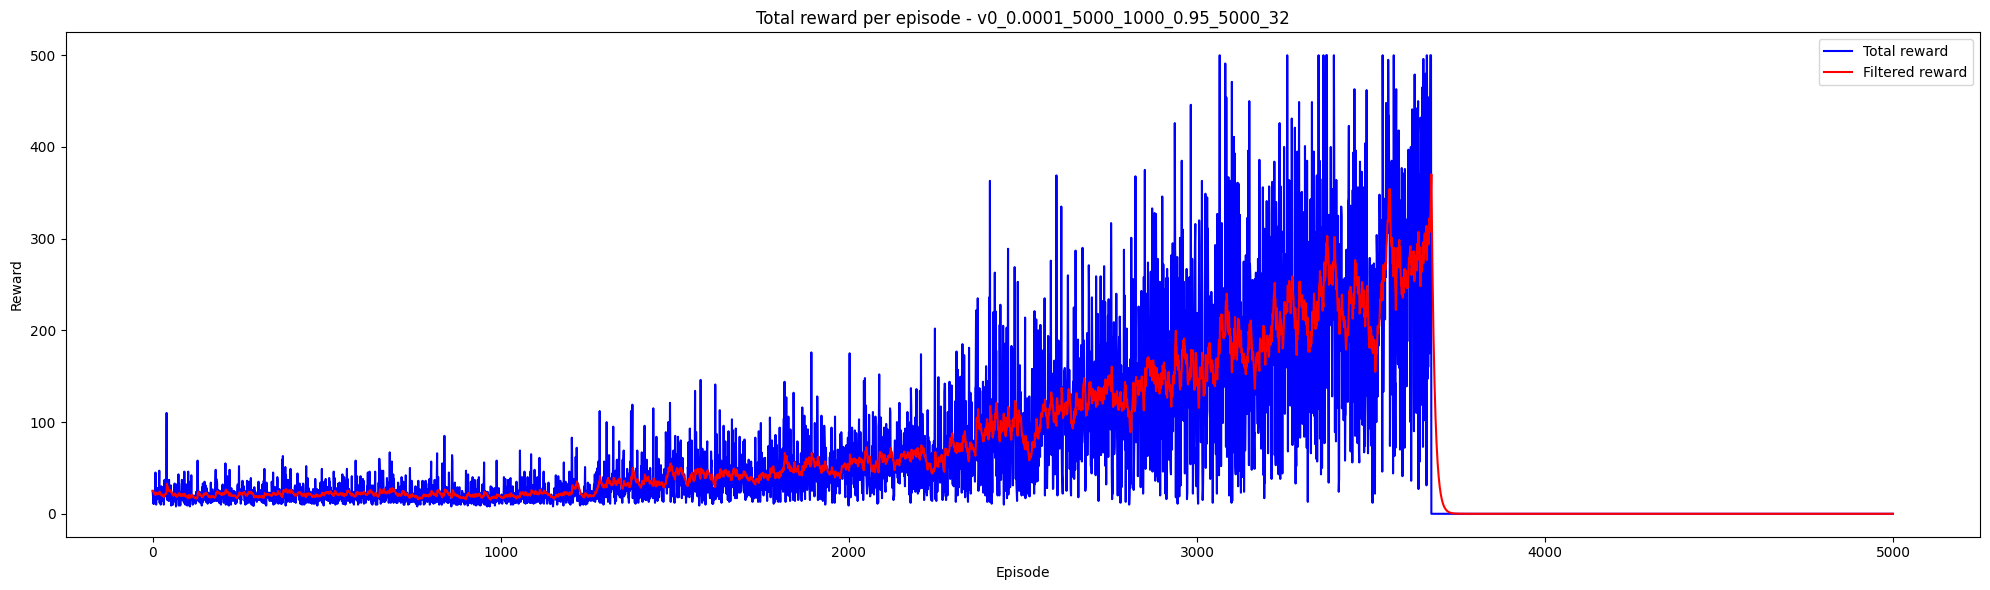

In [10]:
import itertools
import time
keys, values = zip(*param_grid.items())
# keys, values = param_grid.keys(), param_grid.values()
num_config = len(list(itertools.product(*values)))

# Set fixed seed
seed = 42
np.random.seed(seed); random.seed(seed); torch.manual_seed(seed)

for idx, v in enumerate(itertools.product(*values)):

    # Unpacking the hyperparameter configurations
    config = dict(zip(keys,v))
    MODEL_NAME = config['MODEL']                            # Name of the model: "DQN_MLP_v0", "DQN_MLP_v1"
    MODEL_CLASS = model_registry[MODEL_NAME]['class']       # The model class: QNet_MLP,...
    MODEL_CONFIG = model_registry[MODEL_NAME]['config']     # The architecture of the model
    match = re.search(r'v\d+',MODEL_NAME)                   
    MODEL_ID = match.group(0) if match else 404             # The model id: "v0", "v1"

    LR = config['LR']
    BUFFER_SIZE = config['BUFFER_SIZE']
    MIN_REPLAY_SIZE = config['MIN_REPLAY_SIZE']
    TARGET_UPDATE_FREQ = config['TARGET_UPDATE_FREQ']
    GAMMA = config['GAMMA']
    EPS_START = config['EPSILON_START']
    EPS_END = config['EPSILON_END']
    EPS_DECAY = config['EPSILON_DECAY']
    EPISODE_TRAIN = config['EPISODE_TRAIN']
    BATCH_SIZE = config['BATCH_SIZE']


    experiment = DDQN_experiment(MODEL_NAME, model_registry, 
                                 LR, BUFFER_SIZE, TARGET_UPDATE_FREQ, GAMMA, 
                                 EPS_START, EPS_DECAY, EPS_END, 
                                 BATCH_SIZE, seed)
    # Training information
    print(f'Trial {idx+1}/{num_config} - model {MODEL_NAME}, lr={LR}, buffer={BUFFER_SIZE}, target_freq={TARGET_UPDATE_FREQ}, gamma={GAMMA}, eps_decay={EPS_DECAY}, batch_size={BATCH_SIZE}')
    experiment.DDQN_train()
    experiment.DDQN_record()

# Load and Simulate Saved Model 


In [12]:
def load_model(q_network: nn.Module, model_path):
    checkpoint = torch.load(model_path)
    q_network.load_state_dict(checkpoint['model_state_dict'])

In [13]:
def eps_greedy_policy(env, obs, epsilon: float, q_network: QNet_MLP):
    ''' Function to take an action according to an epsilon-greedy policy and a Q-network'''
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(obs).unsqueeze(0)
            q_values = q_network(state_tensor)
            action = q_values.argmax().item()

    return action

In [17]:
# Load a model after training

# Manually select a folder/run to load
run_number = 'run_00014'


# Find the paths to the param_config and model checkpoint
RESULT_DIR = os.path.dirname(experiment.save_path)
RUN_DIR = os.path.join(RESULT_DIR, run_number)
MODEL_PATH = os.path.join(RUN_DIR,'q_network_checkpoint.pth')

# Find the model configuration
with open(os.path.join(RUN_DIR,"param_config.json"),'r') as f:
    data = json.load(f)
model_id = 'DQN_MLP_' + data['parameters']['model_id']
model_config = model_registry[model_id]['config']

# Create the model according to the model version in the model registry
q_network_loaded = QNet_MLP(experiment.obs_space, experiment.act_space, model_config)
load_model(q_network_loaded, MODEL_PATH)

In [19]:
# Create a visual simulation of the network
env_test_visual = gym.make("CartPole-v1")
num_test = 100

for episode in range(num_test):
    obs, _ = env_test_visual.reset()
    done = False
    eps_reward = 0

    while not done:
        action = eps_greedy_policy(env_test_visual, obs, epsilon = 0, q_network=q_network_loaded)
        next_obs, reward, term, trunc, _ = env_test_visual.step(action)

        done = term or trunc
        eps_reward += reward
        obs = next_obs
    
    print(f"Reward from episode {episode:3d} is {eps_reward}")

Reward from episode   0 is 500.0
Reward from episode   1 is 500.0
Reward from episode   2 is 465.0
Reward from episode   3 is 500.0
Reward from episode   4 is 500.0
Reward from episode   5 is 500.0
Reward from episode   6 is 500.0
Reward from episode   7 is 500.0
Reward from episode   8 is 500.0
Reward from episode   9 is 447.0
Reward from episode  10 is 372.0
Reward from episode  11 is 500.0
Reward from episode  12 is 500.0
Reward from episode  13 is 500.0
Reward from episode  14 is 500.0
Reward from episode  15 is 500.0
Reward from episode  16 is 500.0
Reward from episode  17 is 500.0
Reward from episode  18 is 500.0
Reward from episode  19 is 500.0
Reward from episode  20 is 500.0
Reward from episode  21 is 500.0
Reward from episode  22 is 500.0
Reward from episode  23 is 500.0
Reward from episode  24 is 500.0
Reward from episode  25 is 500.0
Reward from episode  26 is 500.0
Reward from episode  27 is 500.0
Reward from episode  28 is 500.0
Reward from episode  29 is 500.0
Reward fro